In [9]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pykalman import KalmanFilter
from datetime import datetime
from numpy import log, polyfit, sqrt, std, subtract
from statsmodels.tsa.stattools import coint, adfuller
import statsmodels.tsa.stattools as ts
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import ffn
import warnings
warnings.filterwarnings('ignore')

In [2]:
def stop_loss(spread, threshold=2):
    return spread > threshold

In [4]:
tickers = [    "JPM", "BAC", "WFC", "C", "GS", "MS", "USB",  # Banking/Finance
    "AAPL", "MSFT", "GOOGL", "META", "NVDA", "ADBE", "TSM", "INTC",  # Technology
    "XOM", "CVX", "COP", "PSX", "SLB", "HAL",  # Energy
    "JNJ", "PFE", "MRK", "LLY", "ABT", "BMY",  # Healthcare
    "PG", "KO", "PEP", "CL", "KMB", "MO",  # Consumer Goods
    "FDX", "UPS", "UNP", "CSX", "NSC",  # Transportation
    "AMT", "PLD", "SPG", "O", "VTR", "DLR",  # Real Estate
    "NEE", "DUK", "SO", "EXC", "XEL", "PEG",  # Utilities
    "VZ", "T", "TMUS", "CHTR",  # Telecommunications
    "NUE", "DD", "LIN", "FCX", "APD", "IFF",  # Materials
    "GE", "BA", "CAT", "MMM", "LMT", "RTX",  # Industrials
    "AMZN", "DIS", "NFLX", "MCD", "SBUX", "YUM"  # Consumer Services
]
df = yf.download(tickers, start = "2015-01-01", end = "2018-01-01")["Close"]
train_data = yf.download(tickers, start="2015-01-01", end = "2018-01-01")["Close"]
test_data = yf.download(tickers, start="2019-01-01", end = "2024-01-01")["Close"]


[*********************100%***********************]  72 of 72 completed
[*********************100%***********************]  72 of 72 completed
[*********************100%***********************]  72 of 72 completed


In [5]:

tickers_sector = [
    ["JPM", "BAC", "WFC", "C", "GS", "MS", "USB"],  # Banking/Finance
    ["AAPL", "MSFT", "GOOGL", "META", "NVDA", "ADBE", "TSM", "INTC"],  # Technology
    ["XOM", "CVX", "COP", "PSX", "SLB", "HAL"],  # Energy
    ["JNJ", "PFE", "MRK", "LLY", "ABT", "BMY"],  # Healthcare
    ["PG", "KO", "PEP", "CL", "KMB", "MO"],  # Consumer Goods
    ["FDX", "UPS", "UNP", "CSX", "NSC"],  # Transportation
    ["AMT", "PLD", "SPG", "O", "VTR", "DLR"],  # Real Estate
    ["NEE", "DUK", "SO", "EXC", "XEL", "PEG"],  # Utilities
    ["VZ", "T", "TMUS", "CHTR"],  # Telecommunications
    ["NUE", "DD", "LIN", "FCX", "APD", "IFF"],  # Materials
    ["GE", "BA", "CAT", "MMM", "LMT", "RTX"],  # Industrials
    ["AMZN", "DIS", "NFLX", "MCD", "SBUX", "YUM"]  # Consumer Services
]


In [13]:
pairs = []
for co_int in tickers_sector:
    data = df[co_int]
    scores, pvalues, sublist_pairs = find_cointegrated_pairs(data)
    pairs.extend(sublist_pairs)
pairs

[('WFC', 'GS'),
 ('WFC', 'MS'),
 ('MSFT', 'ADBE'),
 ('NVDA', 'ADBE'),
 ('NVDA', 'TSM'),
 ('FDX', 'NSC'),
 ('TMUS', 'CHTR'),
 ('LIN', 'APD')]

In [14]:
def position_sizing(spread, risk_factor=0.10):  # Increased risk factor to 0.10
    # Convert spread to pandas Series if it's numpy ndarray
    spread = pd.Series(spread)

    # Compute the volatility of the spread (Rolling Standard Deviation)
    spread_volatility = spread.rolling(window=30).std()

    # Calculate position size based on risk factor and volatility
    position_size = risk_factor / spread_volatility
    return position_size.fillna(0)  # Fill NaNs for the initial period

In [15]:
def find_cointegrated_pairs(dataframe):
    n = dataframe.shape[1]
    score_matrix = np.zeros((n,n))
    pvalue_matrix = np.ones((n, n))
    keys = dataframe.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            stock1 = dataframe[keys[i]]
            stock2 = dataframe[keys[j]]
            result = coint(stock1, stock2) 
            score = result[0]
            score_matrix[i,j] = score
            pvalue = result[1]
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

In [16]:
from pykalman import KalmanFilter
def KalmanFilterAverage(x):
    # Construct a Kalman filter
    kf = KalmanFilter(transition_matrices = [1],
                      observation_matrices = [1],
                      initial_state_mean = 0,
                      initial_state_covariance = 1,
                      observation_covariance=1,
                      transition_covariance=.01)

    # Use the observed values of the price to get a rolling mean
    state_means, _ = kf.filter(x.values)
    state_means = pd.Series(state_means.flatten(), index=x.index)
    return state_means

##########################################################################################

def KalmanFilterRegression(x, y):

    delta = 1e-3
    trans_cov = delta / (1 - delta) * np.eye(2)  # How much random walk wiggles
    obs_mat = np.expand_dims(np.vstack([[x], [np.ones(len(x))]]).T, axis=1)

    kf = KalmanFilter(n_dim_obs=1, n_dim_state=2,  # y is 1-dimensional, (alpha, beta) is 2-dimensional
                      initial_state_mean=[0, 0],
                      initial_state_covariance=np.ones((2, 2)),
                      transition_matrices=np.eye(2),
                      observation_matrices=obs_mat,
                      observation_covariance=2,
                      transition_covariance=trans_cov)

    # Use the observations y to get running estimates and errors for the state parameters
    # Handle potential numerical issues using try-except block
    try:
        state_means, state_covs = kf.filter(y.values)
    except ValueError as e:
        print(f"Error encountered during Kalman Filter estimation: {e}")
        # Handle the error, e.g., by returning NaNs or alternative values
        state_means = np.full((len(y), 2), np.nan)  # Replace with desired error handling
        state_covs = np.full((len(y), 2, 2), np.nan)

    return state_means, state_covs

In [17]:
state_df = pd.DataFrame()
state_df.index = df.index
count = 0
for pair in pairs:
  state_means, state_covs = KalmanFilterRegression(KalmanFilterAverage(df[pair[0]]), KalmanFilterAverage(df[pair[1]]))
  state_df[pair[0] + str(count)] = state_means[:, 0]
  state_df[pair[1] + str(count)] = state_means[:, 1]
  count+=1
for i in range(count):
    state_df['spread' + str(i)] = df[pairs[i][1]] - state_df.iloc[:, 2 * i] - df[pairs[i][0]] * state_df.iloc[:, 2 * i + 1]
     

In [20]:
rolling_window = 60
for i in range(count):
  state_df['spread_mean'+str(i)] = state_df['spread'+str(i)].rolling(rolling_window).mean()
  state_df['spread_std'+str(i)] = state_df['spread'+str(i)].rolling(rolling_window).std()

# Generating Trading Signals
  state_df['z_score'+str(i)] = (state_df['spread'+str(i)] - state_df['spread_mean'+str(i)]) / state_df['spread_std'+str(i)]
  state_df['signal'+str(i)] = 0  # Initialize signal column
  state_df['Sell_signal'+str(i)] = (state_df['z_score'+str(i)] > 1) # Sell signal
  state_df['Buy_signal'+str(i)] = (state_df['z_score'+str(i)] < -1)

In [21]:
filtered_df = pd.DataFrame()
for i in range(count):
    state_df['PnL_' + str(i)] = 0

positions = {}  # Store positions for all pairs

# Initialize positions for each pair
for pair in pairs:
    positions[pair[0]] = 0
    positions[pair[1]] = 0

# Get shared index values between df and state_df
shared_index = df.index.intersection(state_df.index)

for i in range(len(shared_index)):
    idx = shared_index[i]  # Use shared index value

    for j in range(count):  # Iterate through each pair
        pair = pairs[j]

        # Access signals using column names based on pair index
        buy_signal_col = 'Buy_signal' + str(j)
        sell_signal_col = 'Sell_signal' + str(j)

        if state_df.loc[idx, buy_signal_col]:
            positions[pair[0]] += 10  # Buy asset 1
            positions[pair[1]] -= 10 * state_df.loc[idx, pair[1] + str(j)]  # Sell asset 2
        elif state_df.loc[idx, sell_signal_col]:
            positions[pair[0]] -= 10  # Sell asset 1
            positions[pair[1]] += 10 * state_df.loc[idx, pair[1] + str(j)]  # Buy asset 2

        pnl_pair = positions[pair[0]] * df.loc[idx, pair[0]] + positions[pair[1]] * df.loc[idx, pair[1]]
        state_df.loc[idx, 'PnL_' + str(j)] = pnl_pair

# Calculate PnL change for each pair
for i in range(count):
    state_df['PnL_Change_' + str(i)] = state_df['PnL_' + str(i)].pct_change().fillna(0)


In [22]:
for i in range(count):
    print(f"PnL for pair {pairs[i]}:")
    print(state_df[['PnL_' + str(i)]])
     

PnL for pair ('WFC', 'GS'):
                    PnL_0
Date                     
2015-01-02       0.000000
2015-01-05       0.000000
2015-01-06       0.000000
2015-01-07       0.000000
2015-01-08       0.000000
...                   ...
2017-12-22  307012.917116
2017-12-26  298487.224269
2017-12-27  288813.065568
2017-12-28  281836.844675
2017-12-29  273117.322492

[755 rows x 1 columns]
PnL for pair ('WFC', 'MS'):
                   PnL_1
Date                    
2015-01-02      0.000000
2015-01-05      0.000000
2015-01-06      0.000000
2015-01-07      0.000000
2015-01-08      0.000000
...                  ...
2017-12-22 -59654.097502
2017-12-26 -58441.249914
2017-12-27 -57336.449924
2017-12-28 -57157.959225
2017-12-29 -55549.288215

[755 rows x 1 columns]
PnL for pair ('MSFT', 'ADBE'):
                   PnL_2
Date                    
2015-01-02  0.000000e+00
2015-01-05  0.000000e+00
2015-01-06  0.000000e+00
2015-01-07  0.000000e+00
2015-01-08  0.000000e+00
...                  ...
20

In [23]:
for j in range(count):
    state_df[f'weight_{str(pairs[j])}'] = 1/count

for i in range(1, len(shared_index)):
    idx = shared_index[i]

    for j in range(count):
          if state_df.loc[idx, f'PnL_Change_{j}']<-0.3:
            current_weight = (state_df.loc[idx, f'PnL_Change_{j}']) * 0.4 #If more than 40% loses per day reduce weight drastically
          else:
            current_weight = (state_df.loc[idx, f'PnL_Change_{j}']) * 0.2

          state_df.loc[idx, f'weight_{str(pairs[j])}'] += current_weight

In [24]:
for i in range(count):
   state_df[f'weight_{str(pairs[i])}'] = state_df[f'weight_{str(pairs[i])}'].fillna(method='ffill')
   state_df[f'weight_{str(pairs[i])}'] = state_df[f'weight_{str(pairs[i])}'].shift(-1)
   state_df[f'weight_{str(pairs[i])}'] = state_df[f'weight_{str(pairs[i])}'].fillna(0.1)
for i in range(count):
    state_df.loc[:, f'PnL_{i}'] = state_df.loc[:, f'PnL_{i}'] * state_df[f'weight_{str(pairs[i])}']

state_df['cummulative_PnL'] = 0
for i in range(count):
    state_df['cummulative_PnL'] += state_df['PnL_' + str(i)]
     

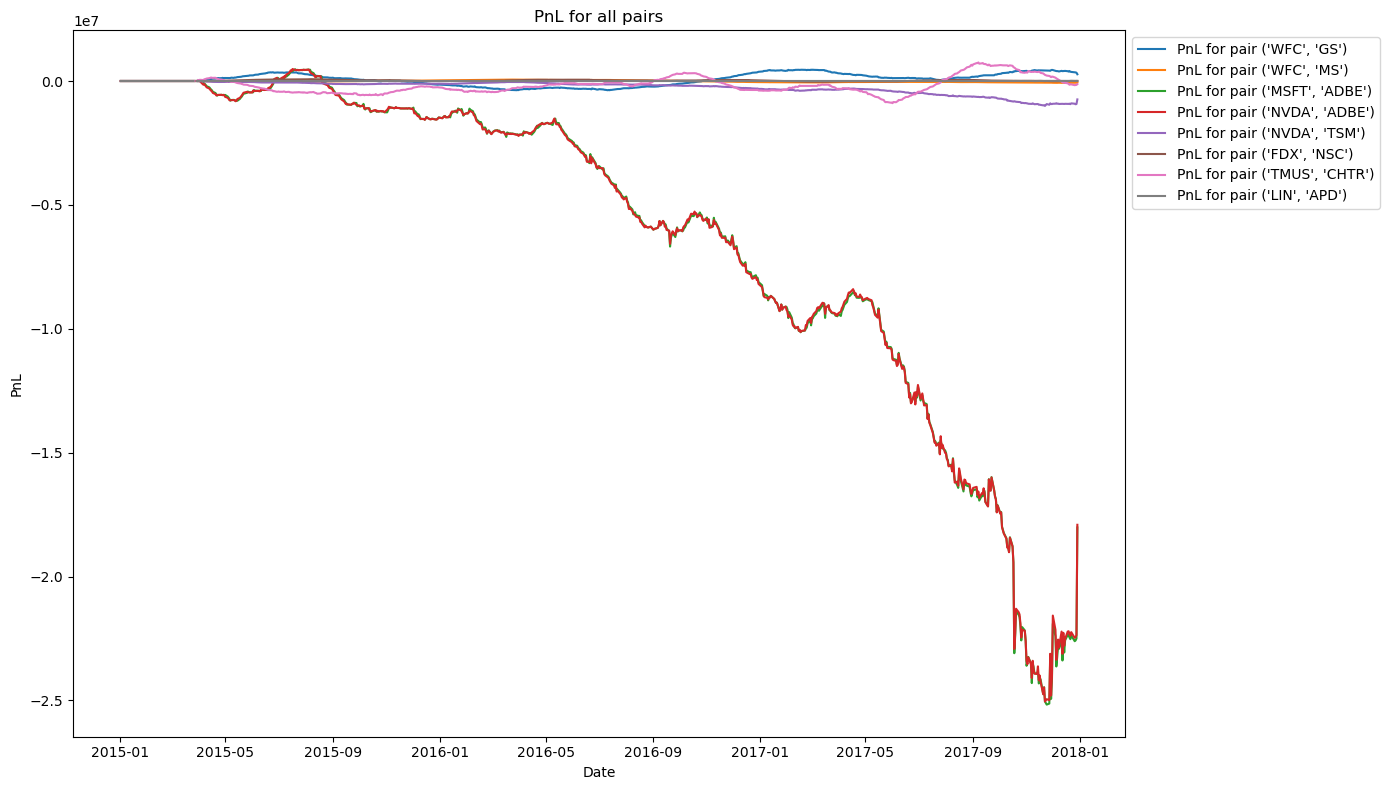

In [25]:
plt.figure(figsize=(14, 8))

for i in range(count):
    plt.plot(state_df.index, state_df['PnL_' + str(i)]*10, label=f'PnL for pair {pairs[i]}')

plt.title('PnL for all pairs')
plt.xlabel('Date')
plt.ylabel('PnL')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()
     

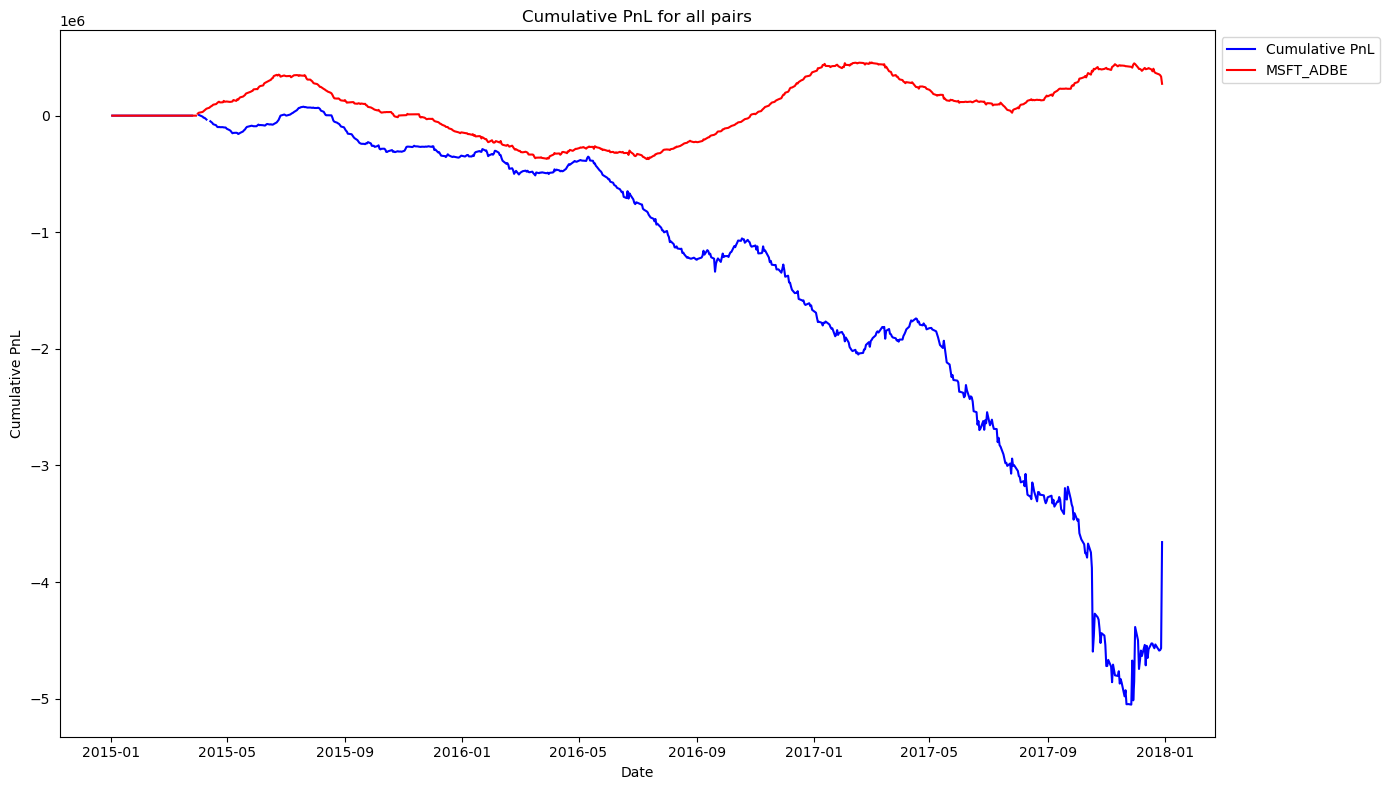

In [26]:
plt.figure(figsize=(14, 8))
plt.plot(state_df.index, state_df['cummulative_PnL'], label='Cumulative PnL', color='blue')
plt.plot(state_df.index, state_df['PnL_0']*10, label='MSFT_ADBE', color='red')
plt.title('Cumulative PnL for all pairs')
plt.xlabel('Date')
plt.ylabel('Cumulative PnL')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

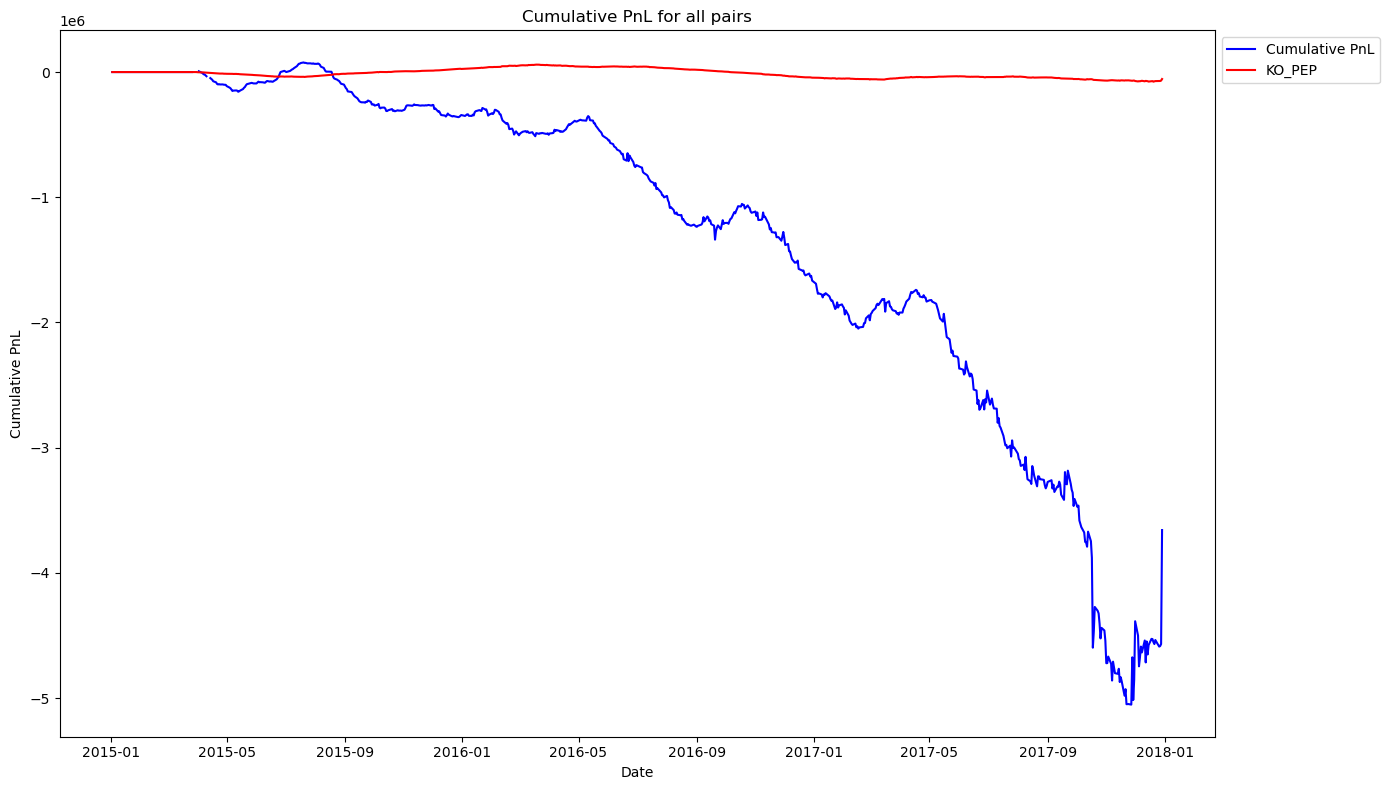

In [27]:


plt.figure(figsize=(14, 8))
plt.plot(state_df.index, state_df['cummulative_PnL'], label='Cumulative PnL', color='blue')
plt.plot(state_df.index, state_df['PnL_1']*10, label='KO_PEP', color='red')
plt.title('Cumulative PnL for all pairs')
plt.xlabel('Date')
plt.ylabel('Cumulative PnL')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

In [28]:
print(f"Final Profit: ${state_df['cummulative_PnL'][-1]:,.2f}")

Final Profit: $-3,657,712.32
